In [1]:
!git clone --depth 1 https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163214, done.
remote: Counting objects: 100% (163214/163214), done.
remote: Compressing objects: 100% (163119/163119), done.
remote: Total 163214 (delta 93), reused 163211 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (163214/163214), 2.00 GiB | 47.59 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Updating files: 100% (182401/182401), done.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import torchvision.models as models
from tqdm import tqdm

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
dataset_path = "PlantVillage-Dataset/raw/color"
img_size = 128
batch_size = 16
num_classes = 38  # Explicitly setting the number of classes

# Image transformations
transform = transforms.Compose([
    # transforms.Resize((img_size, img_size)),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize between -1 and 1
])

classes = os.listdir(dataset_path)
print(f"Total classes: {len(classes)}")


Total classes: 38


In [4]:
# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Splitting dataset: 60% Train, 20% Validation, 20% Test
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
# Extract class names
class_names = full_dataset.classes  # List of actual class names
num_classes = len(class_names)  
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [5]:
# Define U-Net Model for Classification
class UNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(UNetClassifier, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder
        self.dec1 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)

        # Classification head
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)  # Fully connected layer

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.bottleneck(x)
        x = self.dec1(x)
        x = self.dec2(x)

        # Classification Head
        x = self.global_avg_pool(x)  # Reduce to (batch, 64, 1, 1)
        x = torch.flatten(x, 1)  # Flatten to (batch, 64)
        x = self.fc(x)  # Fully connected layer to classify
        return x

In [29]:
# Define ResNet Model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(ResNetClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [39]:
class SegNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(SegNetClassifier, self).__init__()

        self.encoder = models.vgg16(pretrained=True).features  # Using VGG16 as backbone
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # This ensures a fixed-size output
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_avg_pool(x)  # Ensures the correct shape
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [63]:
# Define VGG Model
class VGGClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(VGGClassifier, self).__init__()
        self.model = models.vgg16(pretrained=True)
        
        # Freeze initial layers
        for param in self.model.features.parameters():
            param.requires_grad = False
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [82]:
# Define AlexNet Model
class AlexNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(AlexNetClassifier, self).__init__()
        self.model = models.alexnet(pretrained=True)
        
        # Freeze initial layers
        for param in self.model.features.parameters():
            param.requires_grad = False
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [96]:
class GoogleNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(GoogleNetClassifier, self).__init__()
        self.model = models.googlenet(pretrained=True)
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Modify the last fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [6]:
# Define Inception Model
class InceptionClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(InceptionClassifier, self).__init__()
        self.model = models.inception_v3(pretrained=True)
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Modify the fully connected layer (classifier)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        if self.training:
            logits, aux_logits = self.model(x)
            return logits  # Only return main logits
        else:
            return self.model(x)  # During evaluation, it only returns logits



In [6]:
# Define EfficientNet Model
# class EfficientNetClassifier(nn.Module):
#     def __init__(self, num_classes=38):
#         super(EfficientNetClassifier, self).__init__()
#         self.model = models.efficientnet_v2_s(pretrained=True)
#         self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
#     def forward(self, x):
#         return self.model(x)

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(EfficientNetClassifier, self).__init__()
        self.model = models.efficientnet_v2_s(pretrained=True)
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Modify the classifier (fully connected layer)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [ ]:
# Define Model Classes
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.model = models.vit_b_16(pretrained=True)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class RCNNModel(nn.Module):
    def __init__(self):
        super(RCNNModel, self).__init__()
        self.model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [7]:

# Model setup
# model = UNetClassifier(num_classes=num_classes).to(device)
# model = ResNetClassifier(num_classes=num_classes).to(device)
# model = SegNetClassifier(num_classes=num_classes).to(device)
# model = VGGClassifier(num_classes=num_classes).to(device)
# model = AlexNetClassifier(num_classes=num_classes).to(device)
# model = GoogleNetClassifier(num_classes=num_classes).to(device)
# model = InceptionClassifier(num_classes=num_classes).to(device)
model = EfficientNetClassifier(num_classes=num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 95.2MB/s]
<ipython-input-7-270b84358fd5>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` in

In [8]:
def train(model, train_loader, val_loader, epochs=10):
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
            for images, labels in t:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                t.set_postfix(loss=loss.item())

        train_accuracy = correct / total
        train_acc.append(train_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = correct / total
        val_acc.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Validation Acc: {val_accuracy:.4f}")

        # Step the learning rate scheduler
        scheduler.step()
    
    return train_acc, val_acc


In [9]:
# Train model
train_acc, val_acc = train(model, train_loader, val_loader, epochs=5)

Epoch 1/5:   0%|          | 0/2037 [00:00<?, ?it/s]<ipython-input-8-4316f47d7300>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5: 100%|██████████| 2037/2037 [01:58<00:00, 17.13it/s, loss=1.8]   

Epoch 1/5, Train Acc: 0.8126


Epoch 1/5, Validation Acc: 0.8948


Epoch 2/5: 100%|██████████| 2037/2037 [01:59<00:00, 17.00it/s, loss=0.824] 

Epoch 2/5, Train Acc: 0.8939


Epoch 2/5, Validation Acc: 0.9294


Epoch 3/5: 100%|██████████| 2037/2037 [01:59<00:00, 17.01it/s, loss=0.108] 

Epoch 3/5, Train Acc: 0.9095


Epoch 3/5, Validation Acc: 0.9229


Epoch 4/5: 100%|██████████| 2037/2037 [02:00<00:00, 16.88it/s, loss=0.34]  

Epoch 4/5, Train Acc: 0.9115


Epoch 4/5, Validation Acc: 0.9146


Epoch 5/5: 100%|██████████| 2037/2037 [02:00<00:00, 16.96it/s, loss=0.697] 

Epoch 5/5, Train Acc: 0.9108


Epoch 5/5, Validation Acc: 0.9305


In [10]:
# Save the trained model
# torch.save(model.state_dict(), "unet_trained.pth")
# print("\n🚀 Model saved as unet_trained.pth")
# Save trained model
model_name = model.__class__.__name__  # Get the class name dynamically
model_path = f"{model_name.lower()}_trained.pth"  # Generate filename dynamically
torch.save(model.state_dict(), model_path)
print(f"\n🚀 Model saved as {model_path}")


🚀 Model saved as efficientnetclassifier_trained.pth


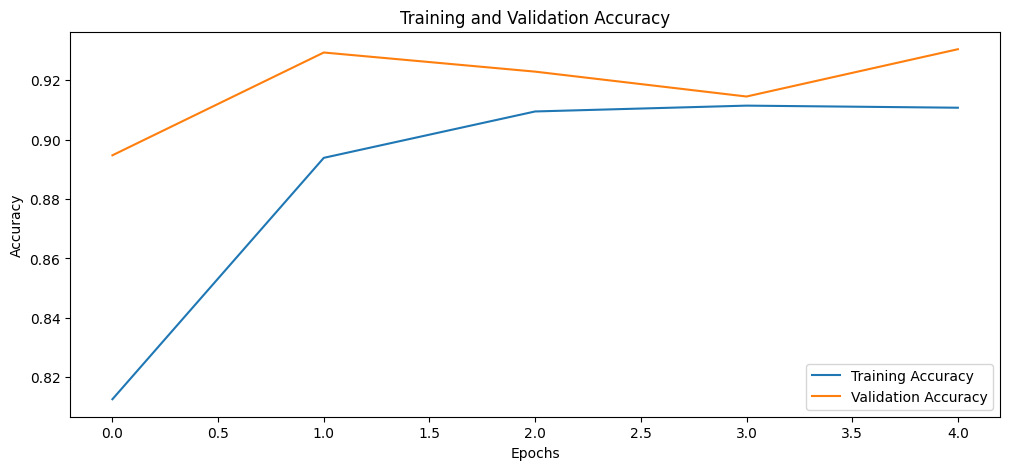

In [11]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [12]:
# Testing the Model
def test(model, test_loader):
    model.eval()
    y_true, y_scores = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return np.array(y_true), np.array(y_scores)

y_true, y_scores = test(model, test_loader)

Test Accuracy: 0.9323


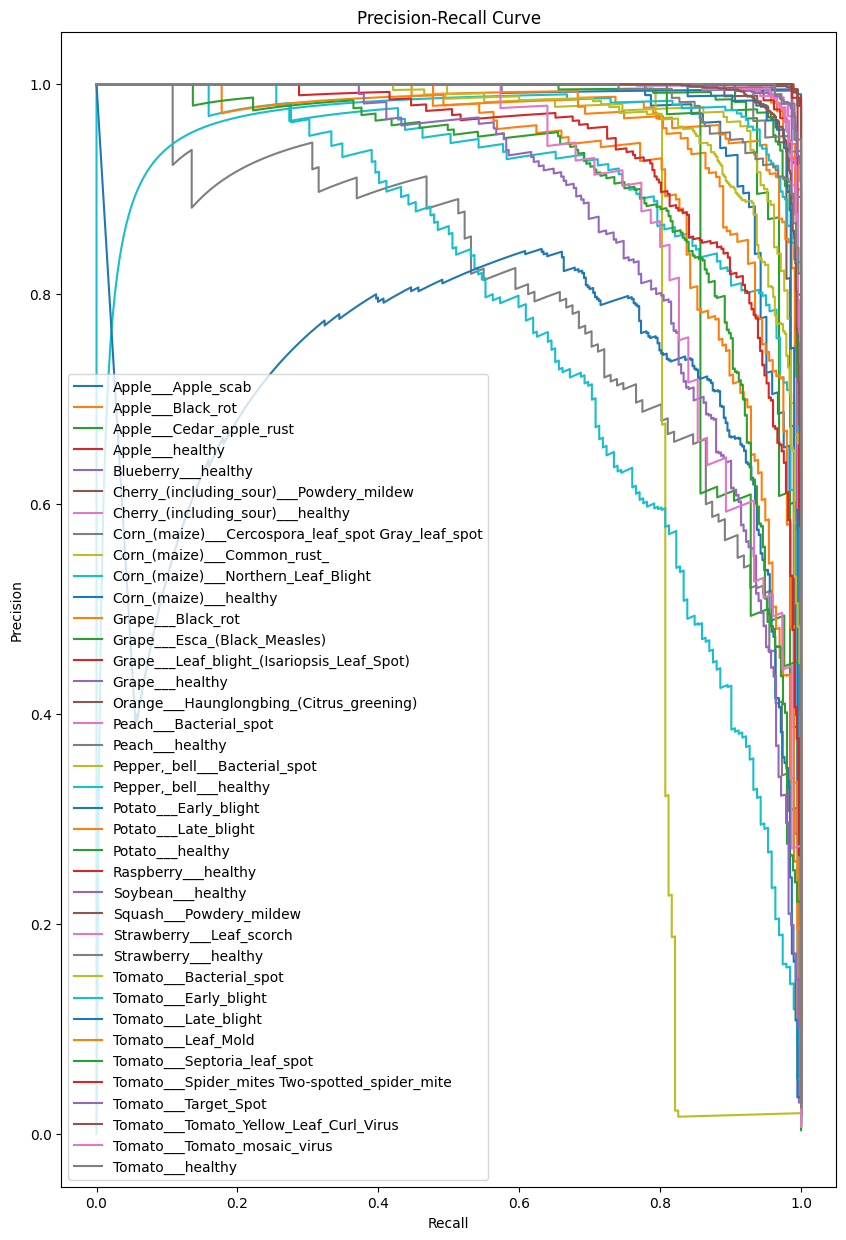

In [13]:
# Compute Precision-Recall Curve with Class Names
precision = dict()
recall = dict()
plt.figure(figsize=(10, 15))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_scores[:, i])
    plt.plot(recall[i], precision[i], label=f'{class_names[i]}')  # Use class name

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
